In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
import glob
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
import seaborn as sns
pd.options.mode.chained_assignment = None
style.use('ggplot') or plt.style.use('ggplot')


### Units used are as in Elmer/Ice:

MPa, a, m
 


In [2]:
# Conversion to Elmer/Ice units

yearinsec = 365.25*24*60*60
rhoi = 900.0/(1.0e6*yearinsec**2)
rhow = 1000.0/(1.0e6*yearinsec**2)
g = -9.8*yearinsec**2


In [3]:
# Lists of fluxes, sigma values (in bed elevation equation) and simulation names

fluxes = [100, 200, 300, 400, 500]
sigmas = [4000, 8000, 12000, 16000]
sims = []

for i in fluxes:
    for j in sigmas:
        sims.append('Flux' + str(i) + 'Sigma' + str(j))


dfs = {}
for sim in sims:
    dfs[sim] = pd.read_csv('../Data/Stress/' + str(sim) + 'm45000.csv')


In [4]:
# Calculate the deviatoric stresses

for sim in sims:
    for i in range(1, 4):
        dfs[sim]['dev stress ' + str(i)] = dfs[sim]['stress ' + str(i)] + dfs[sim]['pressure']


In [5]:
# Re-order data by the y-coordinate and the z-coordinate

for sim in sims:
    dfs[sim]['Points:1'] = dfs[sim]['Points:1']
    dfs[sim] = dfs[sim].sort_values(by=['Points:1', 'Points:2'])
    dfs[sim] = dfs[sim].reset_index(drop=True)
    

In [6]:
# Create dataframe column for the deviatoric stresses

for sim in sims:
    for i in range(1, 4):
        dfs[sim]['dev stress ' + str(i)] = dfs[sim]['stress ' + str(i)] + dfs[sim]['pressure']


In [7]:
# Calculate the hydrostatic pressure at a point if the ice shelf ended at that point

for sim in sims:
    dfs[sim]['hyd. pressure'] = [0] * len(dfs[sim])

for sim in sims:
    for i in range(len(dfs[sim])):
        if dfs[sim]['Points:2'][i] < 0.0:
            dfs[sim]['hyd. pressure'][i] = - rhow * g * dfs[sim]['Points:2'][i]
        else:
            dfs[sim]['hyd. pressure'][i] = 0.0
    
# Subtract the hydrostatic pressure from stess

for sim in sims:
    dfs[sim]['stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure']
    dfs[sim]['dev stress 1 - hyd. p.'] = dfs[sim]['stress 1'] - dfs[sim]['hyd. pressure'] + dfs[sim]['pressure']


In [8]:
# Function to vertically integrate data
# As input, it takes a dataframe, number of vertical nodes, variable and coordinate of interest

def VertInt(df, N, var, coord):
    field = dict.fromkeys(df[coord], 0)
    Coord = dict.fromkeys(df[coord], 0)
    for i in df[coord]:
        Coord[i] += 1
    incorrect_coord_values = [k for k, v in Coord.items() if v != 10]
    correct_coord_values = [k for k, v in Coord.items() if v == 10]
    for i in incorrect_coord_values:
        Coord = {i:Coord[i] for i in Coord if i not in incorrect_coord_values}
        field = {i:field[i] for i in field if i not in incorrect_coord_values}
    df = df[~df[coord].isin(incorrect_coord_values)]
    df_height0 = df[df['height'] < 0.1]
    df_depth0 = df[df['pressure'] < 0.1]
    df_other = df[df['height'] > 0.1]
    df_other = df_other[df_other['pressure'] > 0.1]
    df_height0 = df_height0.reset_index(drop=True)
    df_depth0 = df_depth0.reset_index(drop=True)
    df_other = df_other.reset_index(drop=True)
    for i in range(len(df_other)):
        field[df_other[coord][i]] += df_other[var][i]
    for i in range(len(df_height0)):
        field[df_height0[coord][i]] += 0.5 * df_height0[var][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] += 0.5 * df_depth0[var][i]
    for i in range(len(df_depth0)):
        field[df_depth0[coord][i]] *= df_depth0['height'][i]
    field = {k: v / (N - 1) for k, v in field.items()}
    return field


In [9]:
# Calculate vertically-integrated fields of interest

stress1 = {}
devstress1 = {}
stress1hydp = {}
devstress1hydp = {}
hydp = {}

for sim in sims:
    stress1[sim] = VertInt(dfs[sim], 10, 'stress 1', 'Points:1')
    devstress1[sim] = VertInt(dfs[sim], 10, 'dev stress 1', 'Points:1')
    stress1hydp[sim] = VertInt(dfs[sim], 10, 'stress 1 - hyd. p.', 'Points:1')
    devstress1hydp[sim] = VertInt(dfs[sim], 10, 'dev stress 1 - hyd. p.', 'Points:1')
    hydp[sim] = VertInt(dfs[sim], 10, 'hyd. pressure', 'Points:1')


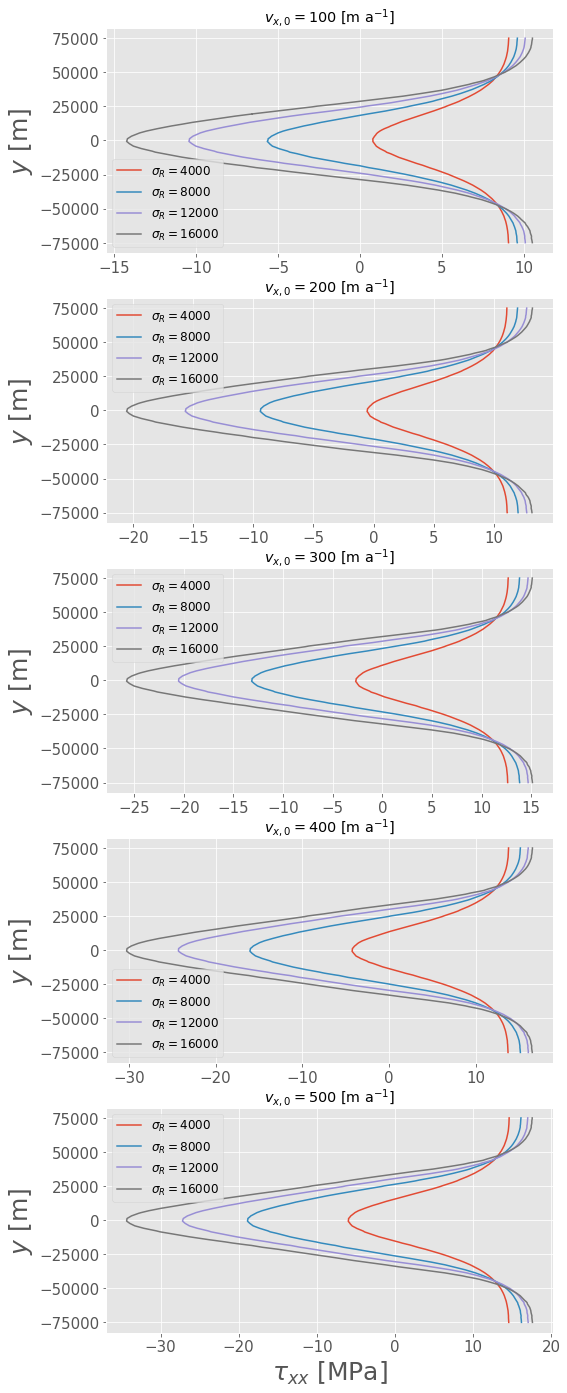

In [10]:
# Plot the deviatoric stress in the x-direction

fig, ax = plt.subplots(len(fluxes), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[i].plot(list(devstress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                    list(devstress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),  \
                    label='$\sigma_R = $' + str(sigmas[j]))  

for i in range(len(fluxes)):
    #ax[i].set_xlim([-20, 10])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$v_{x,0} = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$\tau_{xx}$ [MPa]', size=25)
fig.savefig('../Figures/stress1_sigma.jpg', format='jpg', dpi=500, bbox_inches = "tight")


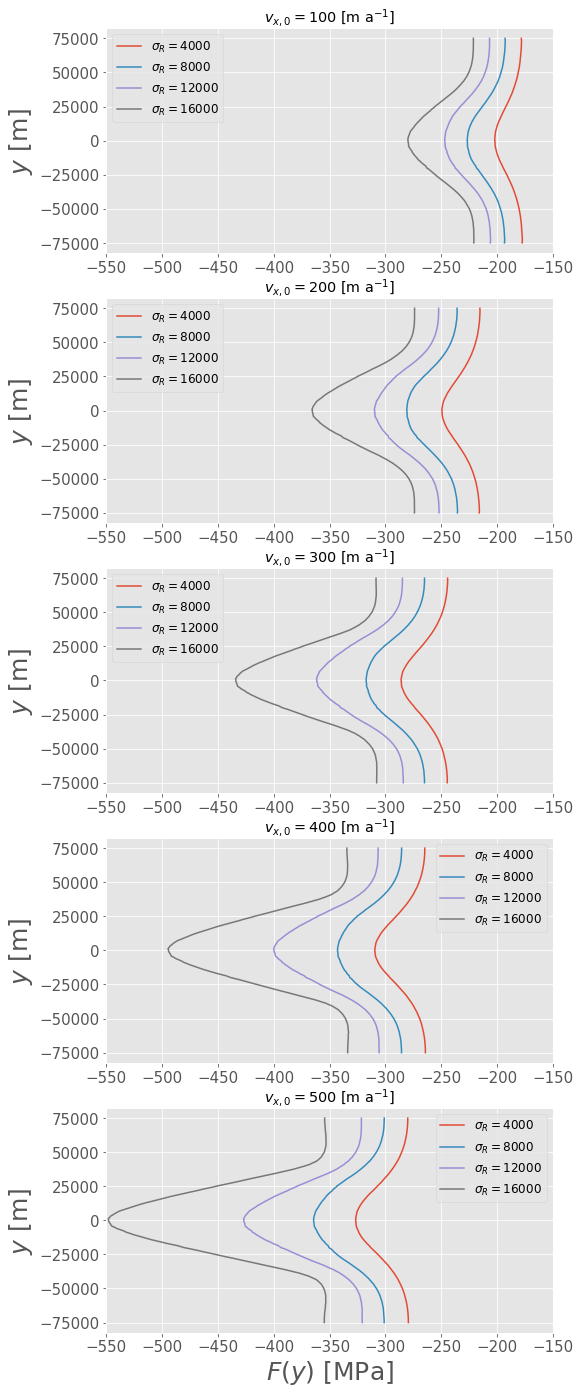

In [11]:
# Plot the stress in the x-direction

fig, ax = plt.subplots(len(fluxes), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[i].plot(list(stress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                   list(stress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),   \
                       label='$\sigma_R = $' + str(sigmas[j]))  

for i in range(len(fluxes)):
    ax[i].set_xlim([-550, -150])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$v_{x,0} = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$F(y)$ [MPa]', size=25)
fig.savefig('../Figures/stress1.jpg', format='jpg', dpi=500, bbox_inches = "tight")


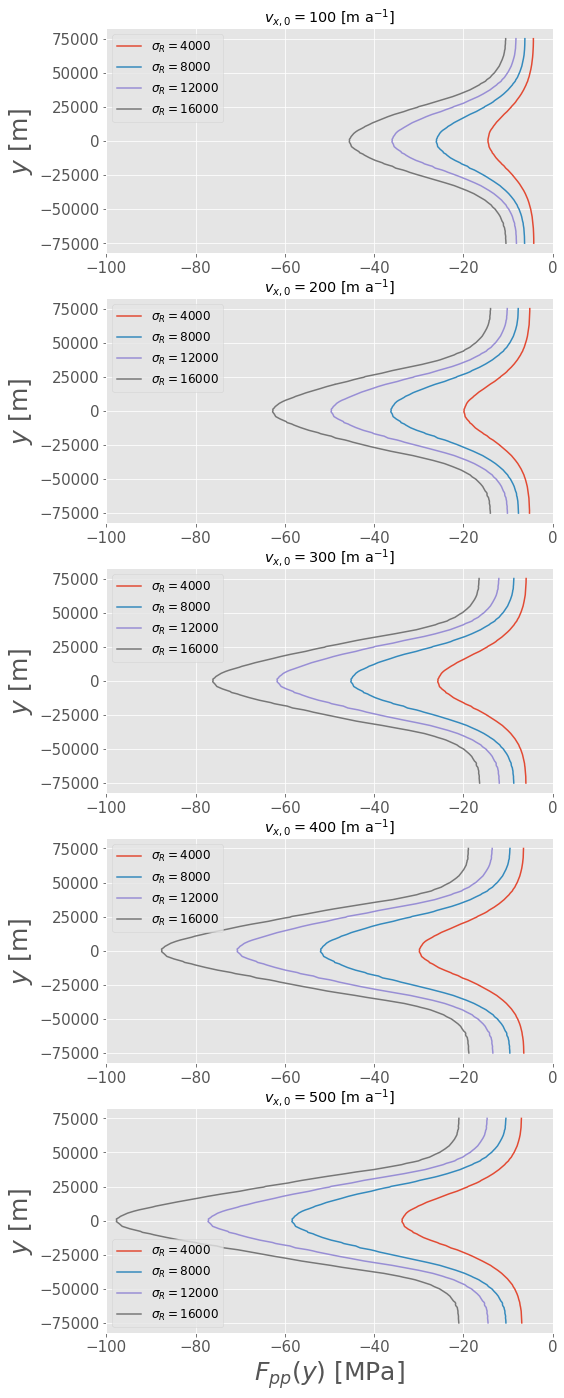

In [12]:
# Plot the stress in the x-direction minus the hydrostatic pressure

fig, ax = plt.subplots(len(fluxes), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[i].plot(list(stress1hydp['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                   list(stress1hydp['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),   \
                       label='$\sigma_R = $' + str(sigmas[j]))  

for i in range(len(fluxes)):
    ax[i].set_xlim([-100.0, 0.0])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$v_{x,0} = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$F_{pp}(y)$ [MPa]', size=25)
fig.savefig('../Figures/stress1_hydp.jpg', format='jpg', dpi=500, bbox_inches = "tight")


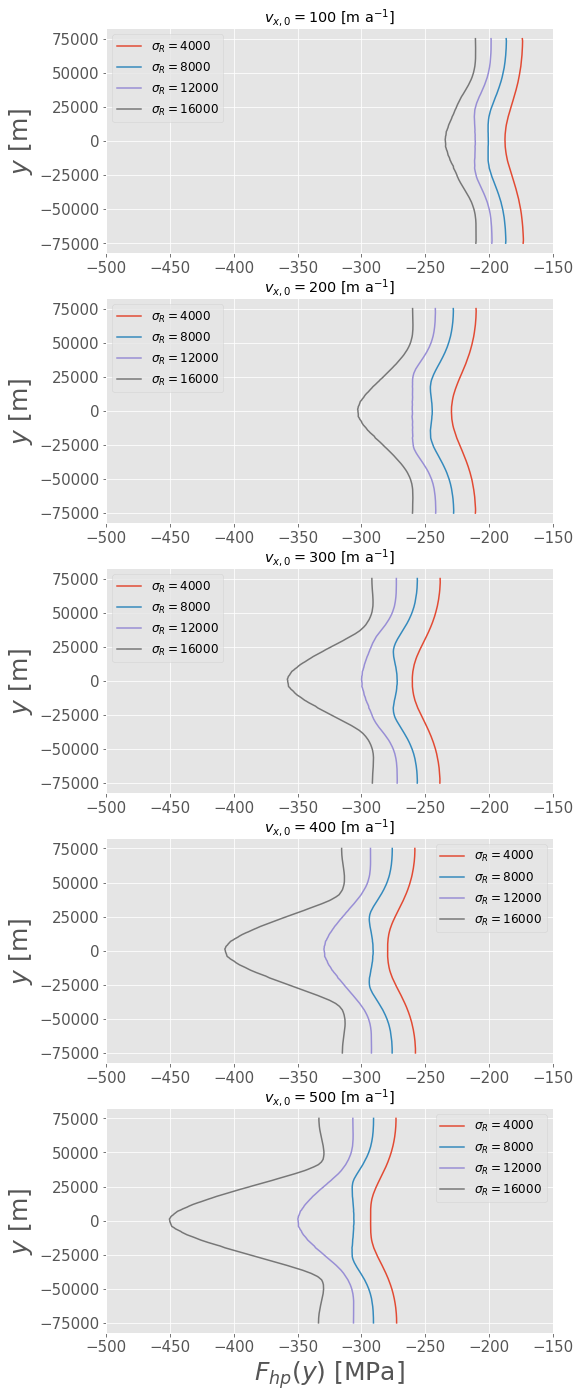

In [13]:
# Plot the hystrostatic pressure

fig, ax = plt.subplots(len(fluxes), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[i].plot(list(hydp['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                   list(hydp['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),   \
                       label='$\sigma_R = $' + str(sigmas[j]))  

for i in range(len(fluxes)):
    ax[i].set_xlim([-500.0, -150.0])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$v_{x,0} = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$F_{hp}(y)$ [MPa]', size=25)
fig.savefig('../Figures/hydp_withoutheight.jpg', format='jpg', dpi=500, bbox_inches = "tight")


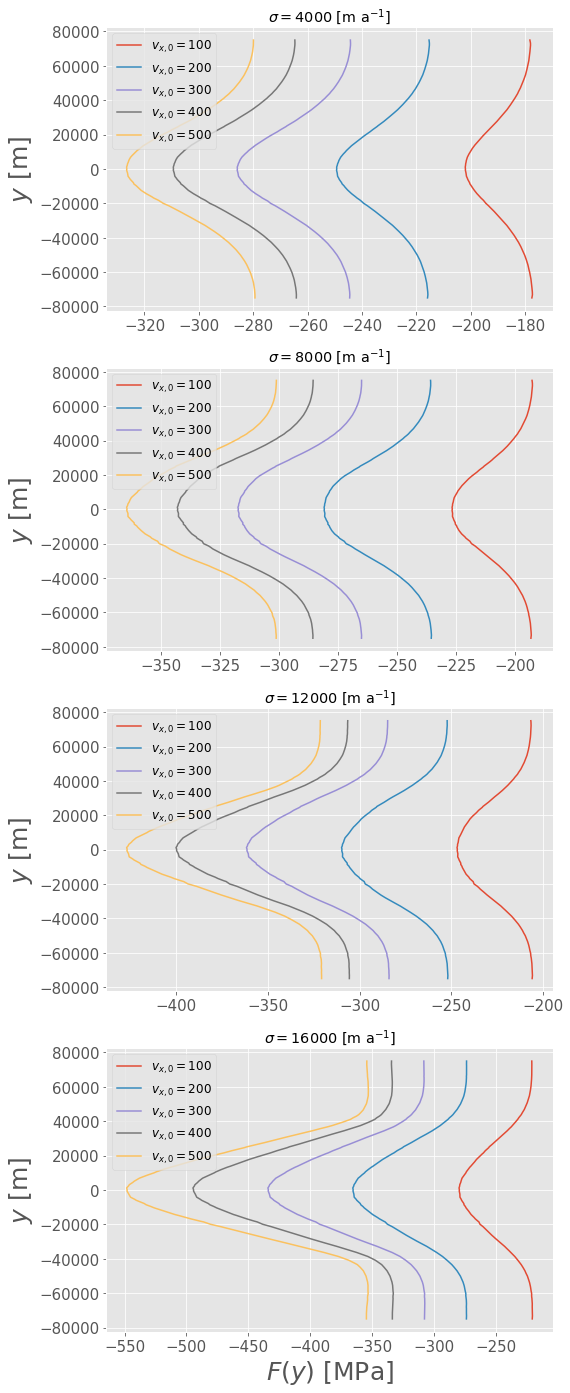

In [14]:
# Plot

fig, ax = plt.subplots(len(sigmas), 1, figsize=(8, 24))
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax[j].plot(list(stress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].values()), \
                   list(stress1['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])].keys()),   \
                       label=r'$v_{x,0} = $' + str(fluxes[i]))  

for i in range(len(sigmas)):
    #ax[i].set_xlim([-40.0, 10.0])
    ax[i].set_ylabel(r'$y$ [m]', size=25)
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].legend(fontsize='12')
    ax[i].title.set_text(r'$\sigma = $' + str(sigmas[i]) + ' [m a$^{-1}$]')
ax[i].set_xlabel(r'$F(y)$ [MPa]', size=25)
fig.savefig('../Figures/stress1_vel.jpg', format='jpg', dpi=500, bbox_inches = "tight")


In [15]:
# Plot the average hydrostatic pressure if the calving front were at this position

def AvHydPressure(g, A, W):
    av_depth = 0.9 * A / (2.0 * W)
    return 0.9 * A * rhow * g * av_depth


In [16]:
# Read in integrated data for each cross-section
# This data is integrated over y and z

Area = {}
StressIntegrated = {}

for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        Area['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])] = \
        pd.read_csv('../Data/StressIntegrated/AreaFlux' + str(fluxes[i]) \
                    + 'Sigma' + str(sigmas[j]) + '.csv')
            
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])] = \
        pd.read_csv('../Data/StressIntegrated/StressFlux' + str(fluxes[i]) \
                    + 'Sigma' + str(sigmas[j]) + '.csv')
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['dev stress 1'] \
        = StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['stress 1'] \
        + StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['pressure']
            
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['hyd p'] = \
        AvHydPressure(g, Area['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['Area'], 150000)[0]
        
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['stress 1 - hyd p'] \
        = StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['stress 1'] \
        - StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['hyd p']
        
        # Find field averages
        
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['point hyd p'] \
        = StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['hyd p'] \
        / Area['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['Area']
        
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['point stress 1'] \
        = StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['stress 1'] \
        / Area['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['Area']
        
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['point stress 1 - hyd p'] \
        = StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['stress 1 - hyd p'] \
        / Area['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['Area']
        
        StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['point dev stress 1'] \
        = StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['dev stress 1'] \
        / Area['Flux' + str(fluxes[i]) + 'Sigma' + str(sigmas[j])]['Area']
        
StressIntegrated['Flux' + str(fluxes[0]) + 'Sigma' + str(sigmas[0])]

,pressure,stress 1,velocity:0,velocity:1,velocity:2,Points:0,Points:1,Points:2,dev stress 1,hyd p,stress 1 - hyd p,point hyd p,point stress 1,point stress 1 - hyd p,point dev stress 1
0,29035000.0,-28095000.0,4.131100e+09,-370620.0,-36673000.0,-45000,29.558,-84.688,940000.0,-2.704934e+07,-1.045664e+06,-0.846006,-0.87871,-0.032705,0.0294


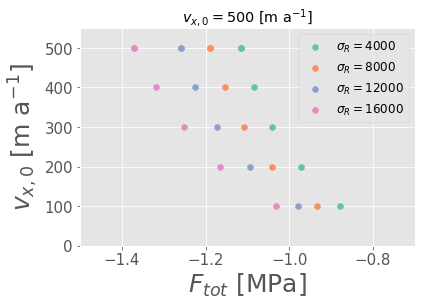

In [17]:
# Plot the average stress in the x-direction (velocity comparison)

colors = sns.color_palette("Set2").as_hex()
fig, ax = plt.subplots(1, 1)
for j in range(len(sigmas)):
    for i in range(len(fluxes)):
        ax.scatter(StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + \
                                       str(sigmas[j])]['point stress 1'][0], \
                                       fluxes[i], color=colors[j])  
    ax.scatter(StressIntegrated['Flux' + str(fluxes[4]) + 'Sigma' + \
                                       str(sigmas[j])]['point stress 1'][0], \
                                       fluxes[i], label=r'$\sigma_R = $' + str(sigmas[j]), color=colors[j])  
ax.set_xlim([-1.5, -0.7])
ax.set_ylim([0,550])
ax.set_ylabel(r'$v_{x,0}$ [m a$^{-1}$]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='12')
ax.title.set_text(r'$v_{x,0} = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax.set_xlabel(r'$F_{tot}$ [MPa]', size=25)
fig.savefig('../Figures/stress1_avg_sigmas.jpg', format='jpg', dpi=500, bbox_inches = "tight")


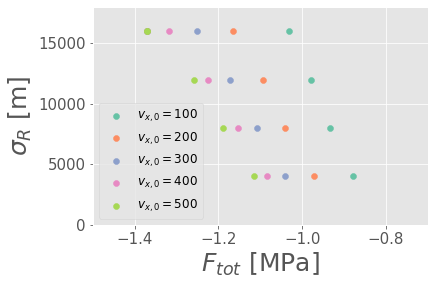

In [18]:
# Plot the average stress in the x-direction (velocity comparison)

colors = sns.color_palette("Set2").as_hex()
fig, ax = plt.subplots(1, 1)
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax.scatter(StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + \
                                       str(sigmas[j])]['point stress 1'][0], \
                                       sigmas[j], color=colors[i])  
    ax.scatter(StressIntegrated['Flux' + str(fluxes[4]) + 'Sigma' + \
                                       str(sigmas[j])]['point stress 1'][0], \
                                       sigmas[j], label=r'$v_{x,0} = $' + str(fluxes[i]), color=colors[i])  
ax.set_xlim([-1.5, -0.7])
ax.set_ylim([0,18000])
ax.set_ylabel(r'$\sigma_R$ [m]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='12')
ax.set_xlabel(r'$F_{tot}$ [MPa]', size=25)
fig.savefig('../Figures/stress1_avg_fluxes.jpg', format='jpg', dpi=500, bbox_inches = "tight")

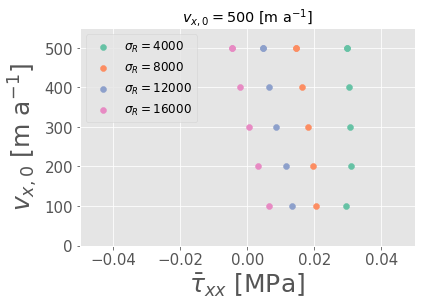

In [19]:
# Plot the average deviatoric stress in the x-direction (velocity comparison)

colors = sns.color_palette("Set2").as_hex()
fig, ax = plt.subplots(1, 1)
for j in range(len(sigmas)):
    for i in range(len(fluxes)):
        ax.scatter(StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + \
                                       str(sigmas[j])]['point dev stress 1'][0], \
                                       fluxes[i], color=colors[j])  
    ax.scatter(StressIntegrated['Flux' + str(fluxes[4]) + 'Sigma' + \
                                       str(sigmas[j])]['point dev stress 1'][0], \
                                       fluxes[i], label=r'$\sigma_R = $' + str(sigmas[j]), color=colors[j])  
ax.set_xlim([-0.05, 0.05])
ax.set_ylim([0,550])
ax.set_ylabel(r'$v_{x,0}$ [m a$^{-1}$]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='12')
ax.title.set_text(r'$v_{x,0} = $' + str(fluxes[i]) + ' [m a$^{-1}$]')
ax.set_xlabel(r'$\bar{\tau}_{xx}$ [MPa]', size=25)
fig.savefig('../Figures/devstress1_avg_sigmas.jpg', format='jpg', dpi=500, bbox_inches = "tight")


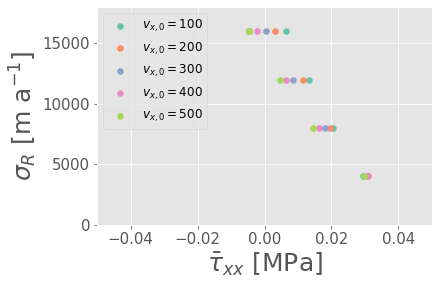

In [20]:
# Plot the average deviatoric stress in the x-direction (velocity comparison)

colors = sns.color_palette("Set2").as_hex()
fig, ax = plt.subplots(1, 1)
for i in range(len(fluxes)):
    for j in range(len(sigmas)):
        ax.scatter(StressIntegrated['Flux' + str(fluxes[i]) + 'Sigma' + \
                                       str(sigmas[j])]['point dev stress 1'][0], \
                                       sigmas[j], color=colors[i])  
    ax.scatter(StressIntegrated['Flux' + str(fluxes[4]) + 'Sigma' + \
                                       str(sigmas[j])]['point dev stress 1'][0], \
                                       sigmas[j], label=r'$v_{x,0} = $' + str(fluxes[i]), color=colors[i])  
ax.set_xlim([-0.05, 0.05])
ax.set_ylim([0,18000])
ax.set_ylabel(r'$\sigma_R$ [m a$^{-1}$]', size=25)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(fontsize='12')
ax.set_xlabel(r'$\bar{\tau}_{xx}$ [MPa]', size=25)
fig.savefig('../Figures/devstress1_avg_fluxes.jpg', format='jpg', dpi=500, bbox_inches = "tight")
